In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import math, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt, pandas as pd
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
noisy_csv = Path("signal_with_motion_artifacts.csv")
clean_csv = Path("motion_free_signal.csv")

noisy_np  = np.loadtxt(noisy_csv,  delimiter=',', dtype=np.float32)
clean_np  = np.loadtxt(clean_csv,  delimiter=',', dtype=np.float32)

noisy_t   = torch.from_numpy(noisy_np)
clean_t   = torch.from_numpy(clean_np)

N          = noisy_t.size(0)
train_size = int(0.8 * N)
perm       = torch.randperm(N)
train_idx, val_idx = perm[:train_size], perm[train_size:]

train_ds = TensorDataset(noisy_t[train_idx], clean_t[train_idx])
val_ds   = TensorDataset(noisy_t[val_idx],   clean_t[val_idx])

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train {len(train_ds)}, Val {len(val_ds)}")


Train 2246, Val 562


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerDenoiser(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=4,
                 dim_feedforward=256, dropout=0.1, max_len=512):
        super().__init__()
        self.in_proj  = nn.Linear(1, d_model)
        self.pos_enc  = PositionalEncoding(d_model, max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, dropout, batch_first=True
        )
        self.encoder  = nn.TransformerEncoder(enc_layer, num_layers)
        self.out_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.in_proj(x.unsqueeze(-1))      # [B, L, d_model]
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.out_proj(x).squeeze(-1)    # [B, L]


In [ ]:
# === hyperparameters ===
NUM_RUNS       = 100        
NUM_EPOCHS     = 200        
PATIENCE       = 20         
TOP_K          = 5          
LR             = 1e-3       

criterion = nn.MSELoss()


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


@torch.inference_mode()
def evaluate(model):
    model.eval()
    mse_total, pcc_list = 0.0, []
    for noisy, clean in val_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        preds = model(noisy)
        mse_total += criterion(preds, clean).item() * noisy.size(0)

        p_np, c_np = preds.cpu().numpy(), clean.cpu().numpy()
        for p, t in zip(p_np, c_np):
            if np.std(t) < 1e-8:
                continue
            pcc_list.append(np.corrcoef(p, t)[0, 1])
    return mse_total / len(val_ds), float(np.mean(pcc_list))


In [ ]:
results = []  # checkpoint of best results

for run in range(1, NUM_RUNS + 1):
    set_seed(run)                               
    model = TransformerDenoiser().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_pcc, best_mse, best_state = -1.0, float("inf"), None
    patience_cnt = 0

    for epoch in range(1, NUM_EPOCHS + 1):
        # === Train ===
        model.train()
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            loss = criterion(model(noisy), clean)
            loss.backward()
            optimizer.step()

        # === Validate ===
        val_mse, val_pcc = evaluate(model)

        # Early‑Stopping 
        if val_pcc > best_pcc:
            best_pcc, best_mse = val_pcc, val_mse
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= PATIENCE:
            break  

    # === record results===
    results.append({
        "run": run,
        "best_pcc": best_pcc,
        "best_mse": best_mse,
        "state_dict": best_state
    })
    print(f"Run {run:03d}|BestPCC={best_pcc:.4f}|BestMSE={best_mse:.6f}")


Run 001 | Best PCC=0.0214 | Best MSE=0.000068
Run 002 | Best PCC=0.0163 | Best MSE=0.000053
Run 003 | Best PCC=0.0131 | Best MSE=0.000073
Run 004 | Best PCC=0.0138 | Best MSE=0.000055
Run 005 | Best PCC=0.0078 | Best MSE=0.000066
Run 006 | Best PCC=0.0001 | Best MSE=0.000112
Run 007 | Best PCC=0.0216 | Best MSE=0.000060
Run 008 | Best PCC=0.0182 | Best MSE=0.000065
Run 009 | Best PCC=0.0090 | Best MSE=0.000052
Run 010 | Best PCC=0.9949 | Best MSE=0.000004
Run 011 | Best PCC=0.0059 | Best MSE=0.000225
Run 012 | Best PCC=0.0219 | Best MSE=0.000055
Run 013 | Best PCC=0.0182 | Best MSE=0.000113
Run 014 | Best PCC=0.0209 | Best MSE=0.000060
Run 015 | Best PCC=0.9934 | Best MSE=0.000002
Run 016 | Best PCC=0.0278 | Best MSE=0.000052
Run 017 | Best PCC=0.0190 | Best MSE=0.000060
Run 018 | Best PCC=0.0083 | Best MSE=0.000068
Run 019 | Best PCC=0.0167 | Best MSE=0.000053
Run 020 | Best PCC=0.0019 | Best MSE=0.000060
Run 021 | Best PCC=0.0238 | Best MSE=0.000053
Run 022 | Best PCC=0.0034 | Best M

In [ ]:
#  Top‑Kvalidation
top_results = sorted(results, key=lambda x: x["best_pcc"], reverse=True)[:TOP_K]

# keep the weight for reevaulation
summary = []
for rank, res in enumerate(top_results, 1):
    fname = f"best_rank{rank}_run{res['run']}_pcc{res['best_pcc']:.4f}.pth"
    torch.save(res["state_dict"], fname)
    #  double‑check
    model = TransformerDenoiser().to(device)
    model.load_state_dict(torch.load(fname, map_location=device))
    val_mse, val_pcc = evaluate(model)
    summary.append({
        "Rank": rank,
        "Run":  res["run"],
        "Saved_File": fname,
        "Val_PCC": round(val_pcc, 4),
        "Val_MSE": round(val_mse, 6)
    })
    print(f"[Top-{rank}]Run{res['run']:03d}|PCC={val_pcc:.4f}|MSE={val_mse:.6f}→Saved{fname}")


pd.DataFrame(summary)


[Top‑1] Run 027 | PCC=0.9984 | MSE=0.000001 → Saved best_rank1_run27_pcc0.9984.pth
[Top‑2] Run 031 | PCC=0.9978 | MSE=0.000001 → Saved best_rank2_run31_pcc0.9978.pth
[Top‑3] Run 025 | PCC=0.9978 | MSE=0.000001 → Saved best_rank3_run25_pcc0.9978.pth
[Top‑4] Run 041 | PCC=0.9957 | MSE=0.000001 → Saved best_rank4_run41_pcc0.9957.pth
[Top‑5] Run 010 | PCC=0.9949 | MSE=0.000004 → Saved best_rank5_run10_pcc0.9949.pth


,Rank,Run,Saved_File,Val_PCC,Val_MSE
0,1,27,best_rank1_run27_pcc0.9984.pth,0.9984,0.000001
1,2,31,best_rank2_run31_pcc0.9978.pth,0.9978,0.000001
2,3,25,best_rank3_run25_pcc0.9978.pth,0.9978,0.000001
3,4,41,best_rank4_run41_pcc0.9957.pth,0.9957,0.000001
4,5,10,best_rank5_run10_pcc0.9949.pth,0.9949,0.000004


In [ ]:

best_ckpt = summary[0]["Saved_File"]          # best model
onnx_name = "denoise_transformer_best.onnx"   # Export as ONNX 


model = TransformerDenoiser().cpu()           # ONNX
model.load_state_dict(torch.load(best_ckpt, map_location="cpu"))
model.eval()


dummy_input = torch.randn(1, 512, dtype=torch.float32)


torch.onnx.export(
    model,
    dummy_input,
    onnx_name,
    export_params=True,
    opset_version=17,          
    do_constant_folding=True,
    input_names = ["noisy_signal"],
    output_names = ["denoised_signal"],
    dynamic_axes = {
        "noisy_signal":   {0: "batch", 1: "seq"},
        "denoised_signal": {0: "batch", 1: "seq"},
    },
)
print(f"ONNX model saved to {onnx_name}")


ONNX model saved to denoise_transformer_best.onnx


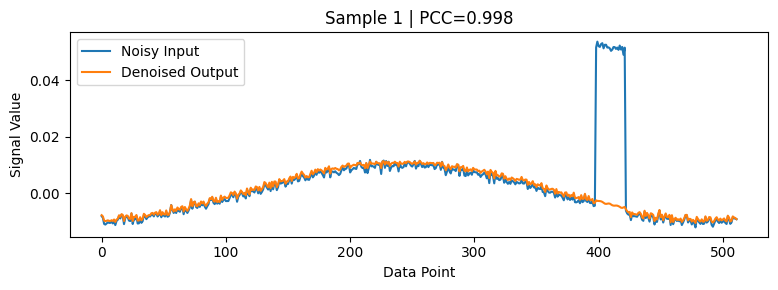

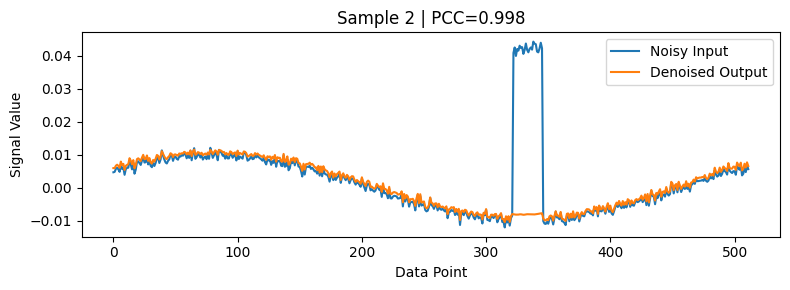

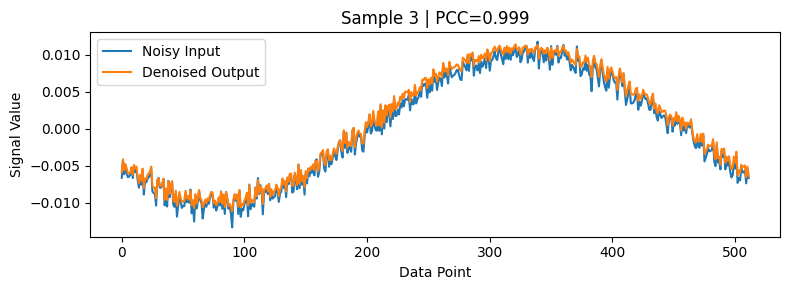

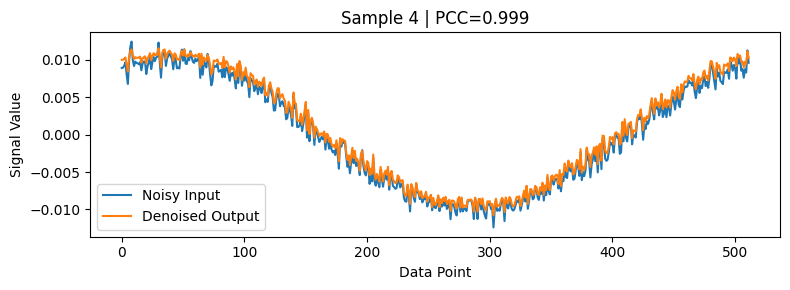

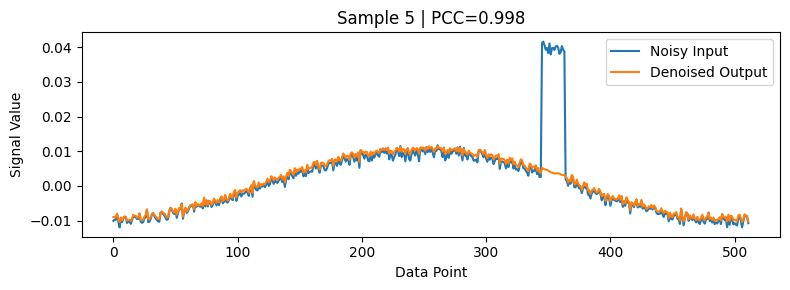

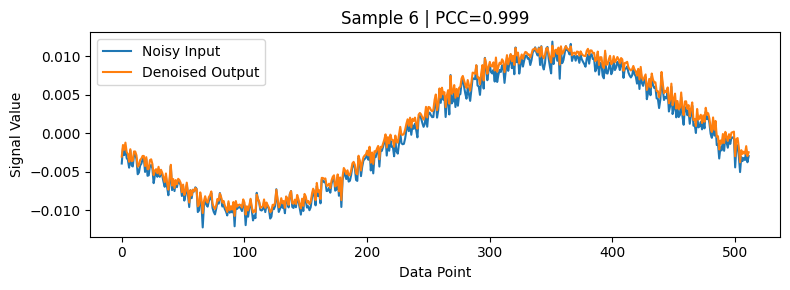

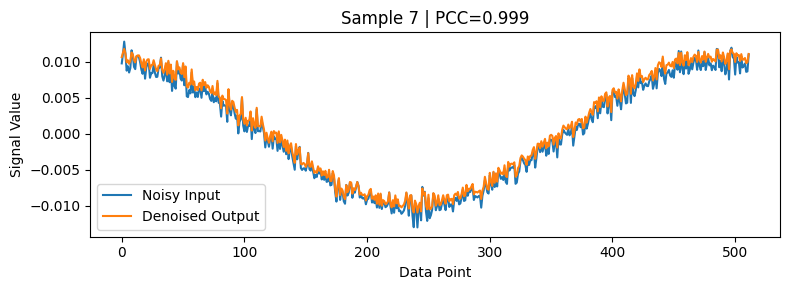

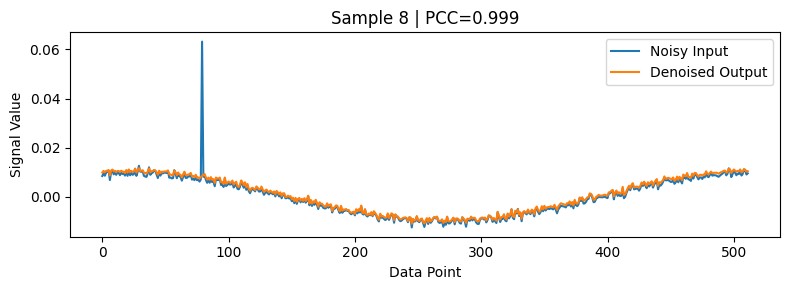

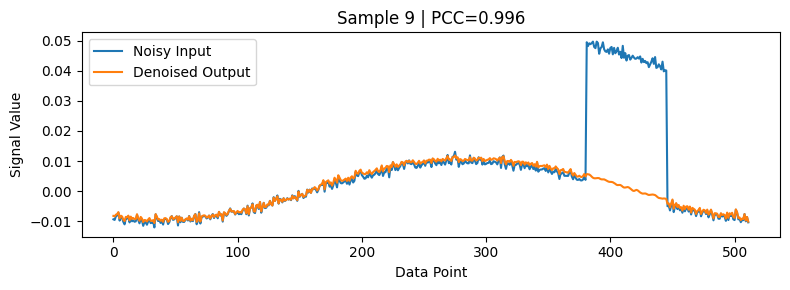

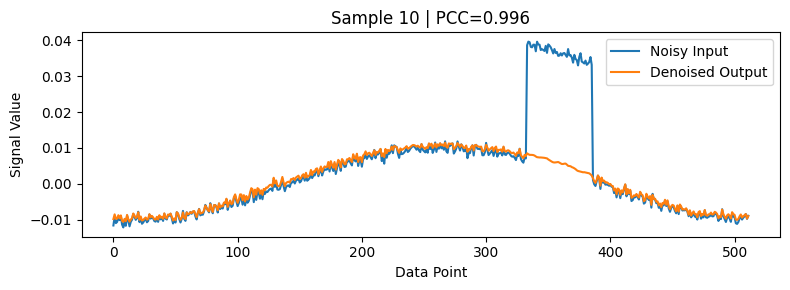

In [ ]:
import matplotlib.pyplot as plt


best_ckpt = summary[0]["Saved_File"]              
model = TransformerDenoiser().to(device)          
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval()


num_show = 10
noisy_samples  = val_ds.tensors[0][:num_show]     # [num_show, 512]
clean_samples  = val_ds.tensors[1][:num_show]     # Ground‑Truth
with torch.inference_mode():
    preds = model(noisy_samples.to(device)).cpu()


for i in range(num_show):
    plt.figure(figsize=(8, 3))
    plt.plot(noisy_samples[i].numpy(),   label="Noisy Input", alpha=1)
    plt.plot(preds[i].numpy(),           label="Denoised Output", alpha=1)
    # ground truth
    # plt.plot(clean_samples[i].numpy(),  label="Ground Truth", alpha=0.7, linestyle="--")
    plt.title(f"Sample {i+1} | PCC={np.corrcoef(preds[i], clean_samples[i])[0,1]:.3f}")
    plt.xlabel("Data Point")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.tight_layout()
    plt.show()
